# DINOv3 Feature Analysis for Glacier Images

This notebook analyzes what DINOv3 learns from glacier imagery by:
1. Extracting DINOv3 features from image patches
2. Using UMAP to visualize the embedding space
3. Checking if features cluster by terrain type (water, ice, debris, etc.)

**Goal**: Understand if DINOv3 features are meaningful for glacier lake detection.

## Step 1: Setup and Imports

In [ ]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
import geopandas as gpd
from rasterio.features import rasterize

# Deep learning
import torch
import torchvision.transforms as transforms
from transformers import AutoModel
from huggingface_hub import login

# Analysis tools
import umap
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns

# Login to HuggingFace
login(token="login-token")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Step 2: Load Data

In [13]:
# File paths
image_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-09-04_fcc_testclip2.tif"
mask_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/lake_mask_testclip2.tif"
glacier_shp_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/clip_by_glacier.shp"

# Load satellite image and lake mask
with rasterio.open(image_path) as src:
    image = src.read()  # Shape: (channels, height, width)
    image = np.transpose(image, (1, 2, 0))  # Change to (height, width, channels)
    image_transform = src.transform
    image_crs = src.crs
    
with rasterio.open(mask_path) as src:
    lake_mask = src.read(1)  # Read first band

print(f"Image shape: {image.shape}")
print(f"Lake mask shape: {lake_mask.shape}")
print(f"Image CRS: {image_crs}")

# Convert to working formats
image_rgb = image[:,:,:3].astype(np.uint8)  # Take only RGB channels
lake_mask_binary = (lake_mask > 0).astype(np.float32)  # Binary lake mask

print(f"RGB image shape: {image_rgb.shape}")
print(f"RGB image range: {image_rgb.min()} - {image_rgb.max()}")

Image shape: (4673, 1362, 4)
Lake mask shape: (4673, 1362)
Image CRS: EPSG:32645
RGB image shape: (4673, 1362, 3)
RGB image range: 70 - 255


In [14]:
# Create glacier mask
def create_glacier_mask(glacier_shp_path, image_shape, image_transform, image_crs):
    """
    Create glacier mask from shapefile
    """
    # Load glacier shapefile
    glacier_gdf = gpd.read_file(glacier_shp_path)
    print(f"Loaded {len(glacier_gdf)} glacier polygons")
    
    # Reproject if needed
    if glacier_gdf.crs != image_crs:
        print(f"Reprojecting from {glacier_gdf.crs} to {image_crs}")
        glacier_gdf = glacier_gdf.to_crs(image_crs)
    
    # Create glacier mask
    glacier_mask = rasterize(
        [(geom, 1) for geom in glacier_gdf.geometry],
        out_shape=image_shape[:2],
        transform=image_transform,
        fill=0,
        dtype=np.uint8
    )
    
    glacier_pixels = glacier_mask.sum()
    total_pixels = glacier_mask.size
    glacier_coverage = glacier_pixels / total_pixels * 100
    
    print(f"Glacier mask: {glacier_pixels:,} pixels ({glacier_coverage:.1f}% of image)")
    
    return glacier_mask.astype(bool)

# Create glacier mask
glacier_mask = create_glacier_mask(glacier_shp_path, image.shape, image_transform, image_crs)
print(f"Glacier mask shape: {glacier_mask.shape}")

Loaded 1 glacier polygons
Reprojecting from EPSG:4326 to EPSG:32645
Glacier mask: 1,409,146 pixels (22.1% of image)
Glacier mask shape: (4673, 1362)


## Step 3: Load DINOv3 Model

In [15]:
# Load DINOv3 model for feature extraction
print("Loading DINOv3 model...")
dinov3_model = AutoModel.from_pretrained("facebook/dinov3-vitb16-pretrain-lvd1689m")
dinov3_model.eval()
dinov3_model = dinov3_model.to(device)

# Transform for DINOv3 input (resize to 224x224)
dinov3_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("DINOv3 model loaded successfully!")

Loading DINOv3 model...
DINOv3 model loaded successfully!


## Step 4: Extract Patches and Labels

In [6]:
def extract_patches_with_labels(image, lake_mask, glacier_mask, patch_size=65, num_patches=500):
    """
    Extract patches with terrain type labels for analysis
    """
    patches = []
    labels = []
    patch_info = []
    
    height, width = image.shape[:2]
    
    # Sample patches across the image
    attempts = 0
    while len(patches) < num_patches and attempts < num_patches * 10:
        # Random location
        y = np.random.randint(0, height - patch_size)
        x = np.random.randint(0, width - patch_size)
        
        # Extract patches
        img_patch = image[y:y+patch_size, x:x+patch_size, :3]
        lake_patch = lake_mask[y:y+patch_size, x:x+patch_size]
        glacier_patch = glacier_mask[y:y+patch_size, x:x+patch_size]
        
        # Calculate coverage statistics
        total_pixels = patch_size * patch_size
        glacier_pixels = glacier_patch.sum()
        lake_pixels = lake_patch.sum()
        
        glacier_coverage = glacier_pixels / total_pixels
        lake_coverage = lake_pixels / total_pixels
        
        # Only include patches with some glacier content
        if glacier_coverage > 0.3:  # At least 30% glacier
            # Classify patch based on dominant terrain type
            if lake_coverage > 0.1:  # >10% lake
                label = "lake"
            elif glacier_coverage > 0.8:  # >80% glacier, no lake
                label = "clean_ice"
            elif glacier_coverage > 0.5:  # Mixed glacier terrain
                label = "debris_covered_ice"
            else:
                label = "mixed_terrain"
            
            patches.append(img_patch)
            labels.append(label)
            patch_info.append({
                'y': y, 'x': x,
                'glacier_coverage': glacier_coverage,
                'lake_coverage': lake_coverage,
                'label': label
            })
        
        attempts += 1
    
    print(f"Extracted {len(patches)} patches after {attempts} attempts")
    
    # Print label distribution
    label_counts = pd.Series(labels).value_counts()
    print("\nLabel distribution:")
    for label, count in label_counts.items():
        print(f"  {label}: {count} patches ({count/len(patches)*100:.1f}%)")
    
    return patches, labels, patch_info

# Extract patches for analysis
print("Extracting patches with terrain labels...")
patches, labels, patch_info = extract_patches_with_labels(
    image_rgb, lake_mask_binary, glacier_mask, 
    patch_size=65, num_patches=500
)

Extracting patches with terrain labels...
Extracted 500 patches after 2037 attempts

Label distribution:
  clean_ice: 378 patches (75.6%)
  debris_covered_ice: 62 patches (12.4%)
  mixed_terrain: 35 patches (7.0%)
  lake: 25 patches (5.0%)


## Step 5: Visualize Sample Patches

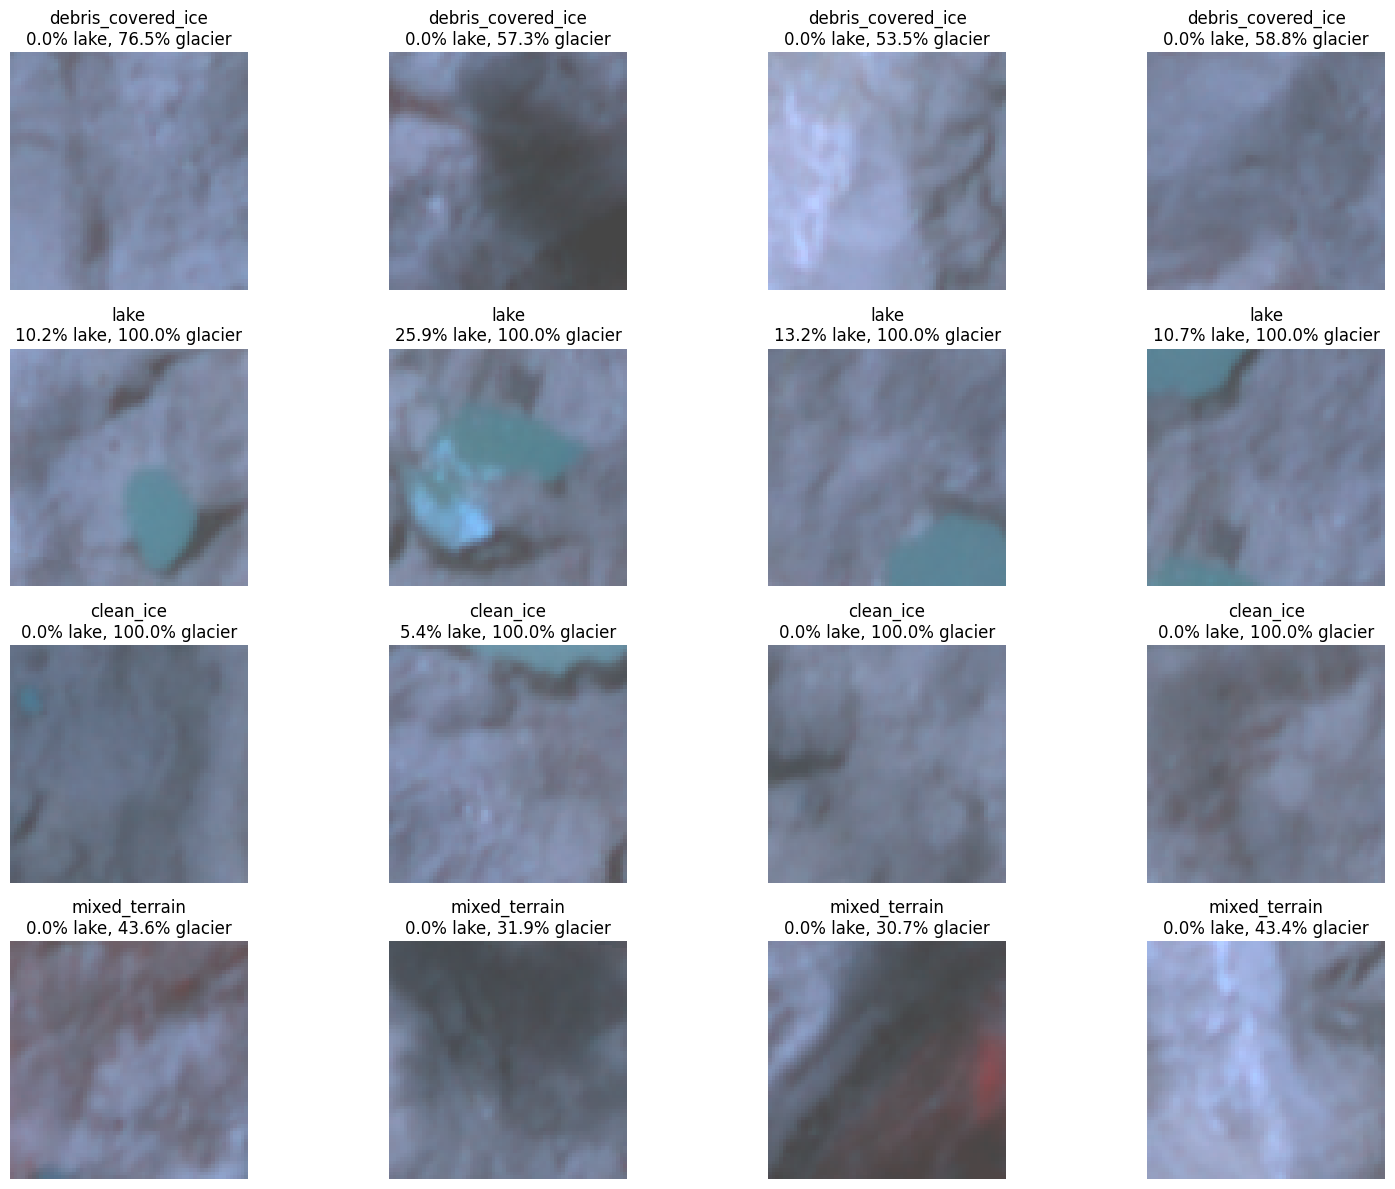

In [7]:
# Visualize sample patches by terrain type
def visualize_patches_by_type(patches, labels, patch_info, samples_per_type=4):
    """
    Show example patches for each terrain type
    """
    unique_labels = list(set(labels))
    
    fig, axes = plt.subplots(len(unique_labels), samples_per_type, figsize=(16, 12))
    if len(unique_labels) == 1:
        axes = axes.reshape(1, -1)
    
    for i, label in enumerate(unique_labels):
        # Find patches with this label
        label_indices = [j for j, l in enumerate(labels) if l == label]
        
        # Show sample patches
        for j in range(min(samples_per_type, len(label_indices))):
            idx = label_indices[j]
            patch = patches[idx]
            info = patch_info[idx]
            
            axes[i, j].imshow(patch)
            axes[i, j].set_title(f'{label}\n{info["lake_coverage"]:.1%} lake, {info["glacier_coverage"]:.1%} glacier')
            axes[i, j].axis('off')
        
        # Clear unused subplots
        for j in range(len(label_indices), samples_per_type):
            axes[i, j].axis('off')
        
        axes[i, 0].set_ylabel(label, rotation=90, size=12)
    
    plt.tight_layout()
    plt.show()

# Visualize patches
visualize_patches_by_type(patches, labels, patch_info)

## Step 6: Extract DINOv3 Features

In [ ]:
def extract_dinov3_features(patches, model, transform, device, batch_size=16):
    """
    Extract DINOv3 features from patches
    """
    all_features = []
    
    print(f"Extracting DINOv3 features from {len(patches)} patches...")
    
    model.eval()
    with torch.no_grad():
        for i in range(0, len(patches), batch_size):
            batch_patches = patches[i:i+batch_size]
            
            # Transform patches
            batch_tensors = []
            for patch in batch_patches:
                patch_tensor = transform(patch)
                batch_tensors.append(patch_tensor)
            
            # Stack into batch
            batch_tensor = torch.stack(batch_tensors).to(device)
            
            # Extract features
            features = model(batch_tensor).last_hidden_state
            
            # Use CLS token as global feature representation
            cls_features = features[:, 0, :]  # Shape: (batch_size, 768)
            
            all_features.append(cls_features.cpu().numpy())
            
            if (i // batch_size + 1) % 10 == 0:
                print(f"  Processed {i + len(batch_patches)}/{len(patches)} patches")
    
    # Concatenate all features
    features_array = np.vstack(all_features)
    print(f"Feature extraction complete! Shape: {features_array.shape}")
    
    return features_array

# Extract DINOv3 features
dinov3_features = extract_dinov3_features(patches, dinov3_model, dinov3_transform, device)

Extracting DINOv3 features from 500 patches...


## Step 7: UMAP Visualization

In [ ]:
# Apply UMAP to reduce dimensionality for visualization
print("Applying UMAP dimensionality reduction...")

# UMAP with different parameters
umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42
)

# Fit UMAP
umap_embedding = umap_reducer.fit_transform(dinov3_features)

print(f"UMAP embedding shape: {umap_embedding.shape}")
print(f"UMAP embedding range: X=[{umap_embedding[:,0].min():.2f}, {umap_embedding[:,0].max():.2f}], Y=[{umap_embedding[:,1].min():.2f}, {umap_embedding[:,1].max():.2f}]")

## Step 8: Visualize Feature Clustering

In [ ]:
# Create DataFrame for analysis
df = pd.DataFrame({
    'umap_x': umap_embedding[:, 0],
    'umap_y': umap_embedding[:, 1],
    'terrain_type': labels,
    'lake_coverage': [info['lake_coverage'] for info in patch_info],
    'glacier_coverage': [info['glacier_coverage'] for info in patch_info]
})

print("DataFrame created with UMAP coordinates and labels")
print(df.head())

In [ ]:
# Plot UMAP embedding colored by terrain type
plt.figure(figsize=(15, 10))

# Main plot: colored by terrain type
plt.subplot(2, 2, 1)
unique_labels = df['terrain_type'].unique()
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = df['terrain_type'] == label
    plt.scatter(df[mask]['umap_x'], df[mask]['umap_y'], 
               c=[color], label=label, alpha=0.7, s=50)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('DINOv3 Features Clustered by Terrain Type')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: colored by lake coverage
plt.subplot(2, 2, 2)
scatter = plt.scatter(df['umap_x'], df['umap_y'], 
                     c=df['lake_coverage'], cmap='Blues', alpha=0.7, s=50)
plt.colorbar(scatter, label='Lake Coverage %')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('Colored by Lake Coverage')
plt.grid(True, alpha=0.3)

# Plot 3: colored by glacier coverage
plt.subplot(2, 2, 3)
scatter = plt.scatter(df['umap_x'], df['umap_y'], 
                     c=df['glacier_coverage'], cmap='Greens', alpha=0.7, s=50)
plt.colorbar(scatter, label='Glacier Coverage %')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('Colored by Glacier Coverage')
plt.grid(True, alpha=0.3)

# Plot 4: Focus on lake vs non-lake
plt.subplot(2, 2, 4)
lake_mask = df['terrain_type'] == 'lake'
plt.scatter(df[~lake_mask]['umap_x'], df[~lake_mask]['umap_y'], 
           c='lightgray', alpha=0.5, s=30, label='Non-lake')
plt.scatter(df[lake_mask]['umap_x'], df[lake_mask]['umap_y'], 
           c='blue', alpha=0.8, s=60, label='Lake')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('Lake vs Non-Lake Separation')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 9: Quantitative Analysis

In [ ]:
# Quantitative analysis of clustering quality
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

# Encode labels for analysis
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Calculate silhouette score for original features
silhouette_original = silhouette_score(dinov3_features, encoded_labels)
print(f"Silhouette Score (original DINOv3 features): {silhouette_original:.3f}")

# Calculate silhouette score for UMAP embedding
silhouette_umap = silhouette_score(umap_embedding, encoded_labels)
print(f"Silhouette Score (UMAP embedding): {silhouette_umap:.3f}")

# K-means clustering on UMAP embedding
n_clusters = len(unique_labels)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(umap_embedding)

# Compare K-means clusters with true labels
ari_score = adjusted_rand_score(encoded_labels, cluster_labels)
print(f"Adjusted Rand Index (K-means vs true labels): {ari_score:.3f}")

print("\nInterpretation:")
print("- Silhouette Score: Higher is better (range: -1 to 1)")
print("- Adjusted Rand Index: Higher is better (range: -1 to 1)")
print("- Good clustering: Silhouette > 0.3, ARI > 0.3")

In [ ]:
# Analyze feature separability for lake detection
def analyze_lake_separability(features, labels, embedding):
    """
    Analyze how well DINOv3 features separate lake from non-lake patches
    """
    # Binary classification: lake vs non-lake
    binary_labels = ['lake' if label == 'lake' else 'non-lake' for label in labels]
    
    lake_indices = [i for i, label in enumerate(binary_labels) if label == 'lake']
    non_lake_indices = [i for i, label in enumerate(binary_labels) if label == 'non-lake']
    
    print(f"Lake patches: {len(lake_indices)}")
    print(f"Non-lake patches: {len(non_lake_indices)}")
    
    if len(lake_indices) > 0 and len(non_lake_indices) > 0:
        # Calculate feature distances
        lake_features = features[lake_indices]
        non_lake_features = features[non_lake_indices]
        
        # Mean distance within groups
        from sklearn.metrics.pairwise import euclidean_distances
        
        lake_distances = euclidean_distances(lake_features)
        non_lake_distances = euclidean_distances(non_lake_features)
        
        # Distance between groups
        between_distances = euclidean_distances(lake_features, non_lake_features)
        
        print(f"\nFeature Separability Analysis:")
        print(f"Average within-lake distance: {lake_distances.mean():.3f}")
        print(f"Average within-non-lake distance: {non_lake_distances.mean():.3f}")
        print(f"Average between-group distance: {between_distances.mean():.3f}")
        
        # Separability ratio (higher is better)
        within_group_avg = (lake_distances.mean() + non_lake_distances.mean()) / 2
        separability_ratio = between_distances.mean() / within_group_avg
        print(f"Separability ratio: {separability_ratio:.3f} (higher is better)")
        
        return separability_ratio
    
    return None

# Analyze separability
separability = analyze_lake_separability(dinov3_features, labels, umap_embedding)

## Step 10: Feature Interpretation

In [ ]:
# Statistical analysis of clusters
print("=== DINOv3 Feature Analysis Summary ===")
print()
print("1. Data Overview:")
print(f"   - Total patches analyzed: {len(patches)}")
print(f"   - Feature dimensionality: {dinov3_features.shape[1]}")
print(f"   - Terrain types found: {len(unique_labels)}")
print()

print("2. Terrain Type Distribution:")
label_counts = pd.Series(labels).value_counts()
for label, count in label_counts.items():
    print(f"   - {label}: {count} patches ({count/len(patches)*100:.1f}%)")
print()

print("3. Clustering Quality:")
print(f"   - Silhouette Score (DINOv3): {silhouette_original:.3f}")
print(f"   - Silhouette Score (UMAP): {silhouette_umap:.3f}")
print(f"   - Adjusted Rand Index: {ari_score:.3f}")
if separability:
    print(f"   - Lake Separability Ratio: {separability:.3f}")
print()

print("4. Interpretation:")
if silhouette_original > 0.3:
    print("   ✅ DINOv3 features show good clustering by terrain type")
else:
    print("   ⚠️  DINOv3 features show weak clustering by terrain type")

if separability and separability > 1.5:
    print("   ✅ Lake features are well-separated from non-lake features")
elif separability:
    print("   ⚠️  Lake features have modest separation from non-lake features")

if ari_score > 0.3:
    print("   ✅ Unsupervised clustering matches terrain types well")
else:
    print("   ⚠️  Unsupervised clustering doesn't match terrain types well")

print()
print("5. Recommendations:")
if silhouette_original > 0.3 and (separability is None or separability > 1.2):
    print("   💡 DINOv3 features are suitable for lake detection training")
    print("   💡 Consider training with current feature extraction approach")
else:
    print("   💡 DINOv3 features may need enhancement (combine with NDWI)")
    print("   💡 Consider hybrid approach: NDWI + DINOv3 refinement")

if len(lake_indices) < 50:
    print("   💡 Need more lake training examples for robust learning")
    print("   💡 Consider expanding dataset or data augmentation")

## Step 11: Save Results

In [ ]:
# Save analysis results
results = {
    'features': dinov3_features,
    'umap_embedding': umap_embedding,
    'labels': labels,
    'patch_info': patch_info,
    'silhouette_original': silhouette_original,
    'silhouette_umap': silhouette_umap,
    'ari_score': ari_score,
    'separability_ratio': separability
}

# Save to file
import pickle
with open('/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_code/dinov3_feature_analysis_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Analysis results saved to dinov3_feature_analysis_results.pkl")

# Save DataFrame for further analysis
df.to_csv('/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_code/umap_results.csv', index=False)
print("UMAP results saved to umap_results.csv")